In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 构建转换器

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

# 下载数据集

In [3]:
trainset = torchvision.datasets.CIFAR10(root='../data',train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

# 检验数据

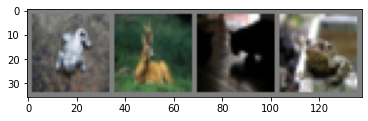

 frog  deer   cat  frog 


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 构造展示图片的函数
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# 从迭代器中读取图片 
dataiter = iter(trainloader)
images,labels = dataiter.next()

# 展示图片
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s ' % classes[labels[j]] for j in range(4) ))

# 定义卷积神经网络

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # 定义卷积层
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        # 定义池化层
        self.pool = nn.MaxPool2d(2,2)
        # 定义全链接层
        self.fc1 = nn.Linear( 16*5*5 ,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 定义损失函数和优化器

In [8]:
import torch.optim as optim
#定义孙是函数，选用交叉熵    
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# 训练


In [9]:
for epoch in range(10):
    running_loss = 0.0
    for i ,data in enumerate(trainloader,0):
        # 取出data
        inputs,labels = data
        # 优化器梯度清零
        optimizer.zero_grad()
        #计算损失
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        #反向传播和参数更新
        loss.backward()
        optimizer.step()
        
        # 累计损失
        running_loss += loss.item()
        
        if (i+1)%4000 == 0:
            print('[%d,%5d] loss:%.3f' % (epoch+1,i+1,running_loss/(i+1)))
            
print('Training Finish')

[1, 4000] loss:2.020
[1, 8000] loss:1.833
[1,12000] loss:1.721
[2, 4000] loss:1.394
[2, 8000] loss:1.372
[2,12000] loss:1.353
[3, 4000] loss:1.232
[3, 8000] loss:1.230
[3,12000] loss:1.222
[4, 4000] loss:1.138
[4, 8000] loss:1.135
[4,12000] loss:1.133
[5, 4000] loss:1.064
[5, 8000] loss:1.063
[5,12000] loss:1.064
[6, 4000] loss:0.989
[6, 8000] loss:1.001
[6,12000] loss:1.006
[7, 4000] loss:0.931
[7, 8000] loss:0.948
[7,12000] loss:0.959
[8, 4000] loss:0.900
[8, 8000] loss:0.912
[8,12000] loss:0.922
[9, 4000] loss:0.856
[9, 8000] loss:0.879
[9,12000] loss:0.891
[10, 4000] loss:0.814
[10, 8000] loss:0.844
[10,12000] loss:0.856
Training Finish


# 保存模型


In [10]:
PATH = '../models/cifar_net.pth'
torch.save(net.state_dict(),PATH)

# 测试
## 获取数据

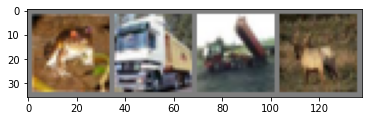

GroundTruth:  frog truck truck  deer 


In [11]:
dataiter = iter(testloader)
images,labels = dataiter.next()

# 打印原始图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s '%classes[labels[j]] for j in range(4)))


## 装载模型测试示例

In [12]:
# 装载模型
net = Net()
net.load_state_dict(torch.load(PATH))

# 预测
outputs = net(images)
_,predicted = torch.max(outputs,1)

print('predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

predicted:  frog truck truck  deer


## 测试集上整体测试准确率

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        
print('Accuracy of the network on 10000 test images:%d %%' %(100*correct/total))

Accuracy of the network on 10000 test images:73 %


In [16]:
# 装载模型
net = Net()
net.load_state_dict(torch.load(PATH))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s  : %2d %%'%(classes[i],100*class_correct[i] / class_total[i] ))

Accuracy of plane  : 78 %
Accuracy of   car  : 85 %
Accuracy of  bird  : 60 %
Accuracy of   cat  : 70 %
Accuracy of  deer  : 57 %
Accuracy of   dog  : 55 %
Accuracy of  frog  : 82 %
Accuracy of horse  : 73 %
Accuracy of  ship  : 85 %
Accuracy of truck  : 81 %


# 利用GPU

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


注意模型和数据都要放到gpu上才可以进行计算
```python
# 将模型转移到gpu上
net.to(device)

#将输入数据和标签张量转移到gpu上
inputs,labels = data[0].to(device),data[1].to(device)

```